# Problem Statement
As there is tremendous usage of Social Media in recent couple of years due to availability of internet or covid-19 circumstances, there's also been increment in cyberbullying via offensive comments or tweets.To prevent cyberbullying we need to build a model to classify tweets into unoffensive,age based,gender based etc.
# Expected Outcome
To classify tweet or comment into 6 classes of cyberbullying


# Dataset
Dataset contains 47000 labelled tweets classified into 6 classes of cyberbullying.Those are:
* Age
* Ethnicity
* Gender
* Religion
* Other type of cyberbullying
* Not cyberbullying

Each class has approximately 8000 tweets.\
**Dataset Link:** https://www.kaggle.com/datasets/andrewmvd/cyberbullying-classification

# Methodology-Text Classification
This is a multi classification task.Analyzing tweets and to find that a specific tweet fall into which class of cyberbullying.

# Importing all neccessary libraries

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding,SpatialDropout1D,Bidirectional
from tensorflow.keras.models import Model
from wordcloud import WordCloud
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

In [20]:
df=pd.read_csv("../input/cyberbullying-classification/cyberbullying_tweets.csv")
print(df.sample(5))

                                              tweet_text   cyberbullying_type
29831  Nothing like a little Colin to cheer up this m...  other_cyberbullying
24829  I have so many ideas and so little time, even ...  other_cyberbullying
38302  the key point is societal. A trans teenager ki...                  age
6698                        #thin http://t.co/Edyxcfk0Jm    not_cyberbullying
16727  @SpeakerPelosi you say the president does not ...             religion


### Viewing Data

In [21]:
df

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying
...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity
47688,Turner did not withhold his disappointment. Tu...,ethnicity
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity


In [22]:
df.info()
print("_____________________________________________________\n\n")
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB
_____________________________________________________


(47692, 2)


In [23]:
df["tweet_text"].describe()

count                                                 47692
unique                                                46017
top       RT @sailorhg: the intro for my hardware hackin...
freq                                                      2
Name: tweet_text, dtype: object

In [24]:
df["cyberbullying_type"].describe()

count        47692
unique           6
top       religion
freq          7998
Name: cyberbullying_type, dtype: object

In [25]:
df.cyberbullying_type.value_counts()

religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: cyberbullying_type, dtype: int64

<AxesSubplot:xlabel='cyberbullying_type', ylabel='count'>

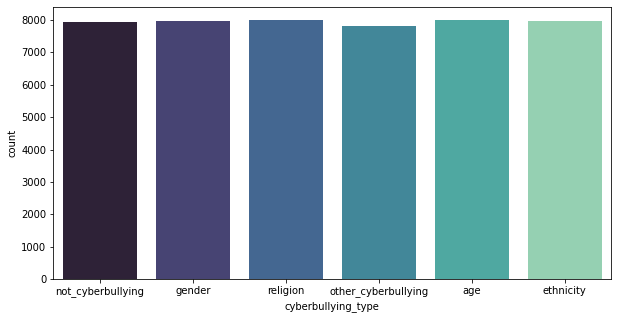

In [26]:
import seaborn as sns
plt.figure(figsize=(10,5))
sns.countplot(df["cyberbullying_type"],palette="mako",)

# Data Cleaning

In [27]:
print(df.isnull().sum())

tweet_text            0
cyberbullying_type    0
dtype: int64


In [28]:
df["tweet_text"].duplicated().sum()

1675

In [29]:
# For lemmatize word
lemma = WordNetLemmatizer()
STOPWORDS = set(stopwords.words('english'))
STOPWORDS.update(['im', 'wa', 'p', 't', 's', 'o', 'e', 'like']) #Customized stop words

def clean_text(text):
    
    # For Removing Hashtag, Mention, https, www.asdfd, dsfadsf.com
    pattern = re.compile(r"(#[A-Za-z0-9]+|@[A-Za-z0-9]+|https?://\S+|www\.\S+|\S+\.[a-z]+|RT @)")
    text = pattern.sub('', text)
    text = " ".join(text.split())
    
    # lowercaseing
    text = text.lower()
    
    # Lemmatizeing words
    text = " ".join([lemma.lemmatize(word) for word in text.split()])
    
    # Removing Punctuations
    remove_punc = re.compile(r"[%s]" % re.escape(string.punctuation))
    text = remove_punc.sub('', text)
    
    # Removing stopwords
    text = " ".join([word for word in str(text).split() if word not in STOPWORDS])

    return text

# Cleaning Tweets

In [30]:
df['tweet_text_clean'] = df.tweet_text.apply(lambda text: clean_text(text))

In [31]:
df

,tweet_text,cyberbullying_type,tweet_text_clean
0,"In other words #katandandre, your food was cra...",not_cyberbullying,word food crapilicious
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,white
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classy whore red velvet cupcakes
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,gio meh thanks head concerned another angry du...
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,isi account pretending kurdish account islam lies
...,...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity,black ppl arent expected anything depended any...
47688,Turner did not withhold his disappointment. Tu...,ethnicity,turner withhold disappointment turner called c...
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity,swear god dumb nigger bitch got bleach hair re...
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity,yea fuck therealexel youre nigger fucking unfo...


### Encoding cyber bullying types in our way and updating in data

In [38]:
ENCODE_DICT = {'not_cyberbullying': 0,
             'gender': 1,
             'religion': 2,
             'other_cyberbullying': 3,
             'age': 4,
             'ethnicity': 5}
df['cyberbullying_type_label'] = df.cyberbullying_type.replace(ENCODE_DICT)
df

,tweet_text,cyberbullying_type,tweet_text_clean,cyberbullying_type_label
0,"In other words #katandandre, your food was cra...",not_cyberbullying,word food crapilicious,0
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,white,0
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classy whore red velvet cupcakes,0
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,gio meh thanks head concerned another angry du...,0
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,isi account pretending kurdish account islam lies,0
...,...,...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity,black ppl arent expected anything depended any...,5
47688,Turner did not withhold his disappointment. Tu...,ethnicity,turner withhold disappointment turner called c...,5
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity,swear god dumb nigger bitch got bleach hair re...,5
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity,yea fuck therealexel youre nigger fucking unfo...,5


# EDA

### Top 20 words in all cyberbullying tweets

In [50]:
from collections import Counter
df['tweet_list'] = df['tweet_text_clean'].apply(lambda x:str(x).split())
top = Counter([item for sublist in df['tweet_list'] for item in sublist])
tweet_list1 = pd.DataFrame(top.most_common(20))
tweet_list1.columns = ['Words','Count']
tweet_list1.style.background_gradient(cmap='Greens')

,Words,Count
0,school,8974
1,fuck,5965
2,dumb,5317
3,girl,5176
4,high,5093
5,u,5036
6,bully,4821
7,people,4820
8,nigger,4781
9,bullied,4652


In [45]:
not_cyberbullying_type = df[df['cyberbullying_type']=='not_cyberbullying']
gender_type = df[df['cyberbullying_type']=='gender']
religion_type = df[df['cyberbullying_type']=='religion']
other_cyberbullying_type = df[df['cyberbullying_type']=='other_cyberbullying']
age_type = df[df['cyberbullying_type']=='age']
ethnicity_type = df[df['cyberbullying_type']=='ethnicity']

### Top 20 words in not cyberbullying type

In [46]:
top20 = Counter([item for sublist in not_cyberbullying_type['tweet_list'] for item in sublist])
type_nc = pd.DataFrame(top20.most_common(20))
type_nc.columns = ['Top of Words','Count']
type_nc.style.background_gradient(cmap='Greens')

,Top of Words,Count
0,bullying,657
1,bully,372
2,dont,371
3,school,356
4,get,347
5,kat,281
6,people,272
7,one,262
8,amp,257
9,go,246


### Top 20 words in gender cyberbullying type

In [47]:
top20_gender = Counter([item for sublist in gender_type['tweet_list'] for item in sublist])
type_g = pd.DataFrame(top20_gender.most_common(20))
type_g.columns = ['Top of Words','Count']
type_g.style.background_gradient(cmap='Greens')

,Top of Words,Count
0,rape,4045
1,joke,4030
2,gay,3768
3,jokes,1202
4,call,1107
5,female,1023
6,people,980
7,bitch,956
8,sexist,956
9,woman,946


### Top 20 words in religion cyberbullying type

In [48]:
top20_r = Counter([item for sublist in religion_type['tweet_list'] for item in sublist])
type_r = pd.DataFrame(top20_r.most_common(20))
type_r.columns = ['Top of Words','Count']
type_r.style.background_gradient(cmap='Greens')

,Top of Words,Count
0,muslim,4075
1,idiot,2709
2,christian,1846
3,u,1768
4,islamic,1237
5,right,1223
6,terrorist,1174
7,woman,1129
8,terrorism,1098
9,support,1071


### Wordcloud for Gender based cyberbullying

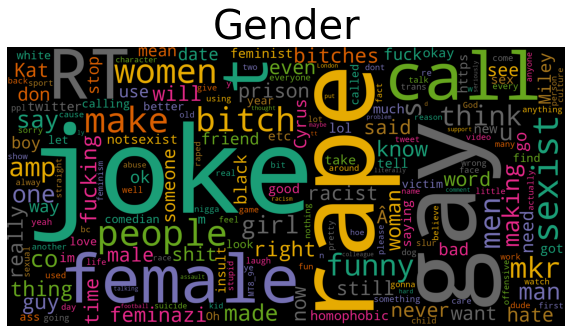

In [52]:
from wordcloud import WordCloud

plt.figure(figsize=(10,10))
subset1 = df[df['cyberbullying_type']=='gender']
text_gender = subset1.tweet_text.values
cloud1=WordCloud(background_color='black',colormap="Dark2",collocations=False,width=2000,height=1000).generate(" ".join(text_gender))

plt.axis('off')
plt.title("Gender",fontsize=40)
plt.imshow(cloud1)

### Wordcloud for Age based cyberbullying

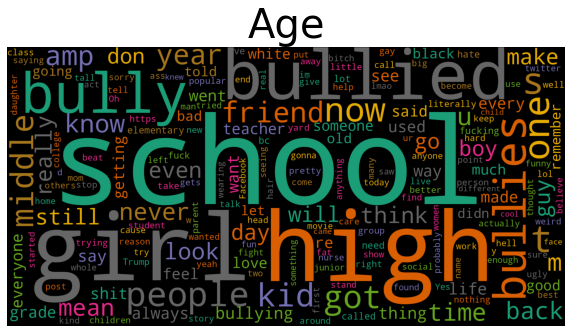

In [53]:
plt.figure(figsize=(10,10))
subset3 = df[df['cyberbullying_type']=='age']
text_age = subset3.tweet_text.values
cloud3=WordCloud(background_color='black',colormap="Dark2",collocations=False,width=2000,height=1000).generate(" ".join(text_age))

plt.axis('off')
plt.title("Age",fontsize=40)
plt.imshow(cloud3)

In [58]:
df

,tweet_text,cyberbullying_type,tweet_text_clean,cyberbullying_type_label,tweet_list,Length
0,"In other words #katandandre, your food was cra...",not_cyberbullying,word food crapilicious,0,"[word, food, crapilicious]",3
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,white,0,[white],1
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classy whore red velvet cupcakes,0,"[classy, whore, red, velvet, cupcakes]",5
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,gio meh thanks head concerned another angry du...,0,"[gio, meh, thanks, head, concerned, another, a...",9
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,isi account pretending kurdish account islam lies,0,"[isi, account, pretending, kurdish, account, i...",7
...,...,...,...,...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity,black ppl arent expected anything depended any...,5,"[black, ppl, arent, expected, anything, depend...",22
47688,Turner did not withhold his disappointment. Tu...,ethnicity,turner withhold disappointment turner called c...,5,"[turner, withhold, disappointment, turner, cal...",29
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity,swear god dumb nigger bitch got bleach hair re...,5,"[swear, god, dumb, nigger, bitch, got, bleach,...",13
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity,yea fuck therealexel youre nigger fucking unfo...,5,"[yea, fuck, therealexel, youre, nigger, fuckin...",10


# Splitting data (75% for training and 25% for testing)

In [39]:
train, test = train_test_split(df, test_size=0.25, random_state=2)

In [40]:
train_tweets = train["tweet_text_clean"]
train_labels = train["cyberbullying_type_label"]
test_tweets = test["tweet_text_clean"]
test_labels = test["cyberbullying_type_label"]

In [41]:
sent_lens=[]
for sent in train_tweets:
    sent_lens.append(len(word_tokenize(sent)))
max(sent_lens)

400

# Finding average words contained by 95% of sentences

In [42]:
max_len = int(np.quantile(sent_lens,0.95))
max_len

30

# Building vocabulary by assining each word a unique number

In [62]:
tweet_tokenizer = Tokenizer()
tweet_tokenizer.fit_on_texts(train_tweets)

In [63]:
vocab_size = len(tweet_tokenizer.index_word.keys())
vocab_size

41985

# Converting each training tweet into numerical form based on vocabulary

In [64]:
training_sequences = tweet_tokenizer.texts_to_sequences(train_tweets)

# Padding numerical sequences so each sequence contains same number of words as 95% of sentences does 

In [65]:
padded_train_tweets = pad_sequences(training_sequences, maxlen = max_len)

In [66]:
padded_train_tweets

array([[    0,     0,     0, ...,     1,  9508,    96],
       [    0,     0,     0, ...,   232,    38,     8],
       [    0,     0,  4123, ...,  1129,   801,   515],
       ...,
       [    0,     0,     0, ...,    29,    40,   112],
       [    0,     0,     0, ..., 41983,   424,   459],
       [    0,     0,     0, ...,  1853,    65,  1378]], dtype=int32)

# Checking for length of sequence as it should be like 95% of sequences

In [67]:
len(padded_train_tweets[0])

30

# Converting training and testing labels lists into arrays

In [68]:
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

# Converting each testing tweet into numerical form based on vocabulary

In [69]:
test_sequences = tweet_tokenizer.texts_to_sequences(test_tweets)
padded_test_tweets = pad_sequences(test_sequences, maxlen = max_len)

# **Model1-LSTM**

In [72]:
from tensorflow.keras import layers
model1 = Sequential()
model1.add(layers.Embedding(vocab_size, max_len)) #The embedding layer
model1.add(layers.LSTM(15,dropout=0.5)) #Our LSTM layer
model1.add(layers.Dense(6,activation='softmax'))
model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 30)          1259550   
_________________________________________________________________
lstm_1 (LSTM)                (None, 15)                2760      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 96        
Total params: 1,262,406
Trainable params: 1,262,406
Non-trainable params: 0
_________________________________________________________________


### Compiling LSTM model
sparse_categorical_crossentropy is for integer target,as we transformed tweets into numerical form sparse_categorical_crossentropy was used.While categorical_crossentropy is for one-hot encoded vectors which takes many parameters to train 

In [77]:
model1.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Checking for dimensions  

In [78]:
print(len(padded_train_tweets),len(train_labels),len(padded_test_tweets),len(test_labels))

35769 35769 11923 11923


### Training LSTM Model
Training with batchsize of 50 and epochs of 100.Callbacks tells time required for each epoch.

In [80]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint1 = ModelCheckpoint("best_model1.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model1.fit(padded_train_tweets, train_labels,batch_size=50, epochs=100,validation_data=(padded_test_tweets, test_labels),callbacks=[checkpoint1])

2022-04-10 15:12:33.217622: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-04-10 15:12:35.355966: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


716/716 [==============================] - 7s 6ms/step - loss: 0.8553 - accuracy: 0.6562 - val_loss: 0.4919 - val_accuracy: 0.7911

Epoch 00001: val_accuracy improved from -inf to 0.79108, saving model to best_model1.hdf5
Epoch 2/100
716/716 [==============================] - 4s 6ms/step - loss: 0.4391 - accuracy: 0.8181 - val_loss: 0.4425 - val_accuracy: 0.8117

Epoch 00002: val_accuracy improved from 0.79108 to 0.81171, saving model to best_model1.hdf5
Epoch 3/100
716/716 [==============================] - 4s 5ms/step - loss: 0.3512 - accuracy: 0.8623 - val_loss: 0.4505 - val_accuracy: 0.8096

Epoch 00003: val_accuracy did not improve from 0.81171
Epoch 4/100
716/716 [==============================] - 4s 5ms/step - loss: 0.2904 - accuracy: 0.8877 - val_loss: 0.4673 - val_accuracy: 0.8120

Epoch 00004: val_accuracy improved from 0.81171 to 0.81196, saving model to best_model1.hdf5
Epoch 5/100
716/716 [==============================] - 4s 5ms/step - loss: 0.2497 - accuracy: 0.9031 - va

### Prediction using testing dataset
predictions1 will be used to calculate confusion matrix

In [81]:
predictions = model1.predict(padded_test_tweets)
predictions1 = np.argmax(model1.predict(padded_test_tweets),axis=1)

### Calculating accuracy

In [82]:
from sklearn.metrics import roc_auc_score
roc_auc_score(test_labels,predictions,multi_class='ovr')

0.942280074270328

## Confusion Matrix

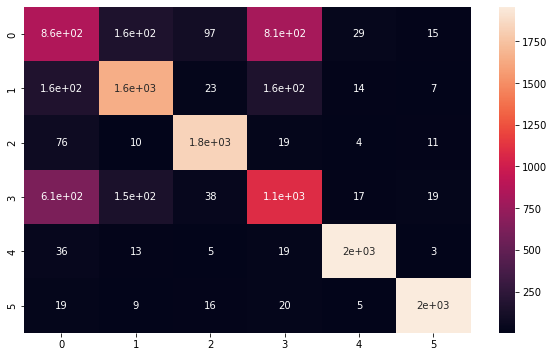

In [83]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(test_labels, predictions1)
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True)
plt.show()

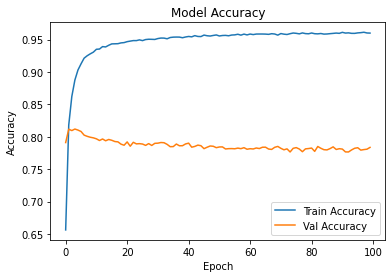

In [90]:
plt.plot(history.history['accuracy'],label='Train Accuracy')
plt.plot(history.history['val_accuracy'],label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# **Model2-Bidirectional LSTM**

In [91]:
from keras.models import Sequential
from keras import layers
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
model2 = Sequential()
model2.add(layers.Embedding(input_dim=vocab_size, output_dim=100, input_length=max_len))
model2.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
model2.add(layers.Dense(6,activation='softmax'))

### Compiling Bidirectional LSTM model
sparse_categorical_crossentropy is for integer target,as we transformed tweets into numerical form sparse_categorical_crossentropy was used.While categorical_crossentropy is for one-hot encoded vectors which takes many parameters to train 

In [92]:
model2.compile(optimizer='rmsprop',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Training Bidirectional LSTM Model
Training with batchsize of 50 and epochs of 50.Callbacks tells time required for each epoch.

In [93]:
checkpoint2 = ModelCheckpoint("best_model2.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model2.fit(padded_train_tweets, train_labels,batch_size=50, epochs=50,validation_data=(padded_test_tweets, test_labels),callbacks=[checkpoint2])

Epoch 1/50
716/716 [==============================] - 10s 9ms/step - loss: 0.7421 - accuracy: 0.6914 - val_loss: 0.4932 - val_accuracy: 0.7669

Epoch 00001: val_accuracy improved from -inf to 0.76692, saving model to best_model2.hdf5
Epoch 2/50
716/716 [==============================] - 6s 9ms/step - loss: 0.4637 - accuracy: 0.7995 - val_loss: 0.4499 - val_accuracy: 0.8161

Epoch 00002: val_accuracy improved from 0.76692 to 0.81607, saving model to best_model2.hdf5
Epoch 3/50
716/716 [==============================] - 6s 9ms/step - loss: 0.4087 - accuracy: 0.8347 - val_loss: 0.4243 - val_accuracy: 0.8240

Epoch 00003: val_accuracy improved from 0.81607 to 0.82404, saving model to best_model2.hdf5
Epoch 4/50
716/716 [==============================] - 6s 9ms/step - loss: 0.3774 - accuracy: 0.8492 - val_loss: 0.4292 - val_accuracy: 0.8235

Epoch 00004: val_accuracy did not improve from 0.82404
Epoch 5/50
716/716 [==============================] - 7s 9ms/step - loss: 0.3510 - accuracy: 0.8

### Prediction using testing dataset
predictions2 will be used to calculate confusion matrix

In [94]:
predictions_model2 = model2.predict(padded_test_tweets)
predictions2 = np.argmax(model2.predict(padded_test_tweets),axis=1)

### Calculating accuracy

In [95]:
roc_auc_score(test_labels,predictions_model2,multi_class='ovr')

0.9562155457520368

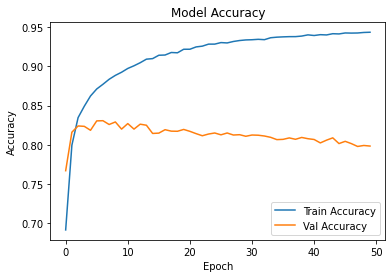

In [96]:
plt.plot(history.history['accuracy'],label='Train Accuracy')
plt.plot(history.history['val_accuracy'],label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Confusion Matrix

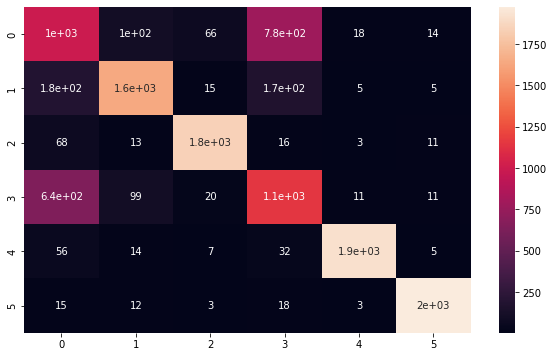

In [97]:
cm2 = confusion_matrix(test_labels, predictions2)
plt.figure(figsize=(10,6))
sns.heatmap(cm2, annot=True)
plt.show()

# **Model3-GRU**

In [98]:
from keras.layers import Dense, Embedding, Dropout, GRU
from keras.models import Sequential
from keras import layers
import tensorflow as tf

model3 = Sequential()
model3.add(Embedding(vocab_size, 100, input_length=max_len))
model3.add(Dropout(0.5))
model3.add(GRU(100))
model3.add(layers.Dense(6, activation='softmax'))

### Compiling GRU model
sparse_categorical_crossentropy is for integer target,as we transformed tweets into numerical form sparse_categorical_crossentropy was used.While categorical_crossentropy is for one-hot encoded vectors which takes many parameters to train 

In [99]:
model3.compile(loss='sparse_categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

### Training GRU Model
Training with batchsize of 50 and epochs of 50.

In [100]:
history = model3.fit(pd.DataFrame(padded_train_tweets), train_labels,epochs=50,
                    verbose=True,
                    validation_data=(pd.DataFrame(padded_test_tweets), test_labels),
                    batch_size=50)

Epoch 1/50
716/716 [==============================] - 6s 6ms/step - loss: 0.6358 - accuracy: 0.7204 - val_loss: 0.4341 - val_accuracy: 0.8045
Epoch 2/50
716/716 [==============================] - 4s 6ms/step - loss: 0.3691 - accuracy: 0.8450 - val_loss: 0.4347 - val_accuracy: 0.8193
Epoch 3/50
716/716 [==============================] - 4s 6ms/step - loss: 0.2718 - accuracy: 0.8904 - val_loss: 0.4656 - val_accuracy: 0.8079
Epoch 4/50
716/716 [==============================] - 4s 6ms/step - loss: 0.2108 - accuracy: 0.9143 - val_loss: 0.5218 - val_accuracy: 0.8021
Epoch 5/50
716/716 [==============================] - 4s 6ms/step - loss: 0.1787 - accuracy: 0.9259 - val_loss: 0.5866 - val_accuracy: 0.7977
Epoch 6/50
716/716 [==============================] - 4s 6ms/step - loss: 0.1559 - accuracy: 0.9342 - val_loss: 0.6018 - val_accuracy: 0.8030
Epoch 7/50
716/716 [==============================] - 4s 6ms/step - loss: 0.1396 - accuracy: 0.9386 - val_loss: 0.6518 - val_accuracy: 0.7980
Epoch 

### Prediction using testing dataset
predictions3 will be used to calculate confusion matrix

In [101]:
predictions_model3 = model3.predict(padded_test_tweets)
predictions3 = np.argmax(model3.predict(padded_test_tweets),axis=1)

### Calculating accuracy

In [102]:
roc_auc_score(test_labels,predictions_model3,multi_class='ovr')

0.9481112350199291

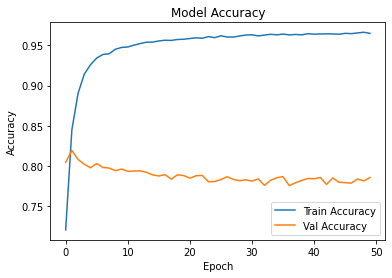

In [103]:
plt.plot(history.history['accuracy'],label='Train Accuracy')
plt.plot(history.history['val_accuracy'],label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Confusion Matrix

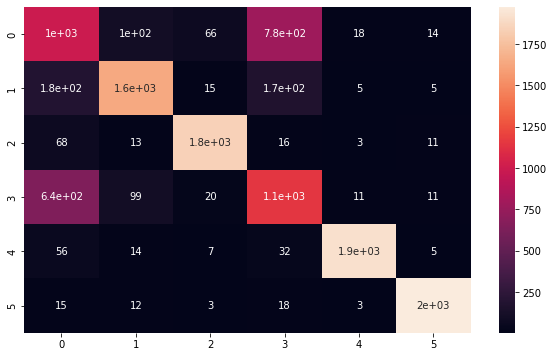

In [104]:
cm3 = confusion_matrix(test_labels, predictions3)
plt.figure(figsize=(10,6))
sns.heatmap(cm2, annot=True)
plt.show()

# Conclusion    
We have got accuracy of 95% for LSTM ,96% approx for Bidirectional LSTM and 95% for GRU.Bidirectional LSTM performed well because it analyses text in both directions and grasp knowledge much better than other algo's.GRU is trained quickly than LSTM but GRU is a bit less accurate than LSTM.The main purpose of GRU is to train quicker than LSTM.